# INTRODUCTION 

Style transfer means taking two images one content image and one style image and use them to create a new image which has the same structure as the content image but the colors and texture of the style image. The ground breaking paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge was the first to use deep learning for style transfer. 
In this notebook we will try to implement Neural style transfer. 

<br>

***References:***
<br>
1. An amazing [blog post](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f) by **Vamshik Shetty** on neural style transfer.
2. Pytorch tutorial on [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) 


***Prerequisites:***
<br>
1. A basic understanding of Python and Pytorch
2. How Convoultion works and vgg models

<br>

***NOTE:*** 
I often interchanged the word stylized image and generate image they both mean the same

# LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms.v2 as T

import random
import os

# CONFIGURATIONS

In [2]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"  
    image_size = (512, 512) if device == 'cuda' else (128, 128)
    seed = 1234


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  

# ensures reprocucibility
seed_everything(CFG.seed) # this function does note effect everyting globally

# Loading Content & Style image

In [3]:
# the next two lines load the content and style image and place them in the working directory
!wget -O content_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
!wget -O style_img.jpg https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg

--2024-10-06 11:11:05--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_content_images/small_room.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378622 (370K) [image/jpeg]
Saving to: 'content_img.jpg'

content_img.jpg     100%[===================>] 369.75K  --.-KB/s    in 0.02s   

2024-10-06 11:11:05 (21.6 MB/s) - 'content_img.jpg' saved [378622/378622]

--2024-10-06 11:11:06--  https://raw.githubusercontent.com/shoabahamed/Nueral-Style-Transfer-Models/master/images/example_style_images/edtaonisl.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|

In [4]:
def get_transforms(img_size=None):
    """
    img_size: (height, width) of content_image
    """
    transforms = []
    
    transforms.append(T.Resize((img_size[0], img_size[1]))) # resize the image to given height and width   
    transforms.append(T.ToImage()) # convert the image to pytorch Image datatype
    transforms.append(T.ToDtype(torch.float32, scale=True)) # convert the image to torch float32 and scales the values between 0 and 1
    transforms.append(T.ToPureTensor()) 
    
    return T.Compose(transforms)

def load_image(image_name, transforms):
    """
    Load the image using PIL and transforms the image appropiately for training
    """
    image = Image.open(image_name).convert('RGB')
    image = transforms(image).unsqueeze(0).contiguous() # need to make sure the image is placed contigously 
    return image


def display_image(img, ax=None, title=""):
    """
    Takes in batch img of form (1, C, H, W) and display the image
    """
    if ax is None:
        ax = plt.gca() # get current axis
        
    img = img.cpu().numpy()[0]
    img = np.transpose(img, axes=(1, 2, 0)) # (C, H, W) -> (H, W, C)
    
    plt.sca(ax)
    plt.imshow(img)
    plt.title(title)


# content and style path
content_path = "/kaggle/working/content_img.jpg" 
style_path = "/kaggle/working/style_img.jpg"  

content_transforms = get_transforms(CFG.image_size)
style_transforms = get_transforms(CFG.image_size)
content_img =  load_image(content_path, content_transforms)
style_img = load_image(style_path, style_transforms)

assert content_img.shape == style_img.shape, "style and content shape does not match"

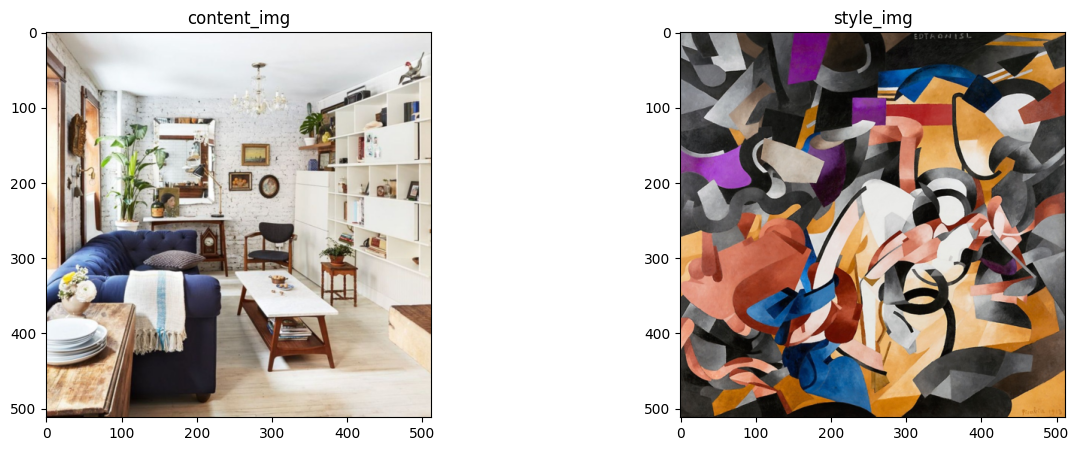

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")

# HOW NEURAL STYLE TRANSFER WORK

<img src="https://github.com/shoabahamed/Nueral-Style-Transfer-Models/blob/master/images/model_images/ArtisticNeuralStyleTransfer/original.jpg?raw=True" style="display:block; margin: auto" title="how style transfer work">
<p style="text-align: center; margin-top:1rem">Fig:<a href="https://devpost.com/software/imageblender#updates"> <u>How Neural Style work</u></a></p>

We have three images a content image, a generated(a white noise/content img/style img) img and a style img. We extract the feature maps from different layers of a pretrained vgg network. In the paper they used pretrained vgg19 model. Then we would compare the feature map of content img and generated img to calculate the content loss. Furthermore we would use the feature maps of style img and generated img to calculate the style loss. After that you would the content loss and style to calculate the toal loss. Then we would calculate the gradients of generated images's each pixel and update their pixel values. We would iterate the process until we get a good stylized image.

Usually for content image your would only take one feature map. In the paper they used the output of relu4_2 layer. For style loss you would use the feature map of many layers. In the paper they used the output of 'relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'layer which gives better result then using just one layer. We would explain why this is the case later in the notebook.

***Content Loss:*** Content loss simply the mean squared loss between content image feature map and generated image feature map 

***Style Loss:*** To understand style loss you have to understand something called gram matrix first. The Gram matrix is a square matrix that represents the inner products of a set of vectors. In our case the vectors are the channels in the feature map. For the feature map of size (C, H, W) in layer ***l*** of the network we can calculate the gram matrix in these three steps:
1. change the shape of the feature maps from (C, H, W) to (C, H*W)
2. get the inner product of (C, H*W) using matrix multiplication of (C, H*W) and (H*W, C)
3. normalize the gram matrix by dividing by (C*H*W)

[image] 

We calculate the the gram matrix feature maps at different layers for both style img and generated img and simply get their mean squared loss and sum them up. But what do these gram matrix represent?



> You can think of gram matrix here as the correlation between different channels in feature maps. We trying to tell the model that if two a feature map always occurs on the style image at the same time then also want the same to happend to our generated stylized image. Suppose we have feature maps (C, H, W) at l layer of the network for style image. If small red shapes and small blue shapes always appear in the stylize image we also want them to occur in our stylized image

In [6]:
def get_gram_matrix(feature_map):
    """
    calculates the gram matrix given features maps of layer l
    """
    # feature_map: (Batch_Size, Channels, Height, Width): here Batch_Size would be 1 in our case
    
    B, C, H, W = feature_map.size() 
    # (Batch_Size, Channels, Height, Width) -> (Channels, Height*Width)
    features = feature_map.view(B*C, H*W)
    # (Channels, Height*Width) @ (Height*Width, Channels) -> (Channels, Channels)
    gram_matrix = torch.mm(features, features.t()) 
    
    return gram_matrix.div(C*W*H) # normalizing the gram matrix according to the paper 

# MODEL

In this section we will create the model and load the pretrained weights. If you have looked at other style transfer tutorial they mostly used pytorch pretrained vgg19 weightst. But we won't be using that but use weights where the images were normalized the same way as the vgg paper as they seem to work better for style transfer and these weights would be used extensively in many following papers and also in our other notebooks. The weights used are taken from [here](https://github.com/pietrocarbo/deep-transfer)

In [7]:
# the network structure of vgg19 till relu5_1 as we will at most need the relu5_1 output
enc_layers = nn.Sequential( 
    nn.Conv2d(3,3,(1, 1)),  # this is an extra preprocessing layer

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(), # relu1_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(), # relu1_2
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(), # relu2_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(), # relu2_2
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,256,(3, 3)),
    nn.ReLU(), # relu3_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(), # relu3_4

    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,512,(3, 3)),
    nn.ReLU(), # relu4_1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(), # relu4_2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(), # relu4_3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(), # relu4_4
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),

    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(), # relu5_1
) 

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu1_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.relu1_2 = nn.Sequential(*enc_layers[4:7]) # relu1_1 -> relu1_2
        self.relu2_1 = nn.Sequential(*enc_layers[7:11])  # relu1_2 -> relu2_1
        self.relu2_2 = nn.Sequential(*enc_layers[11:14]) # relu2_1 -> relu2_2
        self.relu3_1 = nn.Sequential(*enc_layers[14:18]) # relu2_2 -> relu3_1
        self.relu3_2 = nn.Sequential(*enc_layers[18:21]) # relu3_1 -> relu3_2
        self.relu3_3 = nn.Sequential(*enc_layers[21:24]) # relu3_3 -> relu3_3
        self.relu3_4 = nn.Sequential(*enc_layers[24:27]) # relu3_3 -> relu3_3
        self.relu4_1 = nn.Sequential(*enc_layers[27:31]) # relu3_4 -> relu4_1
        self.relu4_2 = nn.Sequential(*enc_layers[31:34]) # relu4_1 -> relu4_2
        self.relu4_3 = nn.Sequential(*enc_layers[34:37]) # relu4_2 -> relu4_3
        self.relu4_4 = nn.Sequential(*enc_layers[37:40]) # relu4_3 -> relu4_4
        self.relu5_1 = nn.Sequential(*enc_layers[40:44]) # relu4_4 -> relu5_1

        # Freeze the layers to prevent training them
        for param in self.parameters():
            param.requires_grad_(False)

    def forward(self, x):
        """
        x: (Batch_Size, Channels, Height, Width)
        output: dictionary containing the feature maps of all relu layers
        """
        output = {}
        
        x = self.relu1_1(x)
        output['relu1_1'] = x 
        
        x = self.relu1_2(x)
        output['relu1_2'] = x 
        
        x = self.relu2_1(x)
        output['relu2_1'] = x 
        
        x = self.relu2_2(x)
        output['relu2_2'] = x 
        
        x = self.relu3_1(x)
        output['relu3_1'] = x 

        x = self.relu3_2(x)
        output['relu3_2'] = x  
        
        x = self.relu3_3(x)
        output['relu3_3'] = x 
        
        x = self.relu3_4(x)
        output['relu3_4'] = x 
        
        x = self.relu4_1(x)
        output['relu4_1'] = x 
        
        x = self.relu4_2(x)
        output['relu4_2'] = x 
        
        x = self.relu4_3(x)
        output['relu4_3'] = x 
        
        x = self.relu4_4(x)
        output['relu4_4'] = x 
        
        x = self.relu5_1(x)
        output['relu5_1'] = x 
        
        return output



In [8]:
feature_extractor = FeatureExtractor()
enc_layers.load_state_dict(torch.load("/kaggle/input/style-transfer-models/pytorch/default/1/pretrained/vgg19-encoder/vgg_normalised_conv5_1.pth",map_location=CFG.device))

<All keys matched successfully>

# TRAINING

In [9]:
# the code below is mostly taken from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def run_style_transfer(model, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                       content_layer_weights, style_layer_weights, style_weight=100000, content_weight=1,
                       num_steps=300, learning_rate=1):
    
    # moving the images and model to appropiate devices
    content_img = content_img.to(CFG.device)
    style_img = style_img.to(CFG.device)
    generated_img = generated_img.to(CFG.device)
    model = model.to(CFG.device)
    optimizer = torch.optim.LBFGS([generated_img], lr=learning_rate) # we are using LBFGS optimizer as it was used in paper
    
    # We want to optimize the input img and not the model parameters 
    generated_img.requires_grad_(True)
    model.requires_grad_(False)
    
    
    # saving the content and style image feature maps
    model.eval()
    with torch.no_grad():
        content_feats = model(content_img)
        style_feats = model(style_img)
        style_gram_matrices = {layer_name: get_gram_matrix(feature_map) for layer_name, feature_map in style_feats.items()}

        
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # clamping the values between valid image range of 0 and 1
            with torch.no_grad():
                generated_img.clamp_(0, 1)

            optimizer.zero_grad()
            
            total_style_loss = 0.0
            total_content_loss = 0.0
            
            # generated images feature maps
            stylized_feats = model(generated_img)
            
            # calculating content loss and weight each layer's loss
            for idx, output_layer_name in enumerate(content_layers_name):
                content_loss = F.mse_loss(stylized_feats[output_layer_name], content_feats[output_layer_name])
                total_content_loss += content_loss * content_layer_weights[idx]

            # calculating style loss and weight each layer's loss
            for idx, output_layer_name in enumerate(style_layers_name):
                stylized_gram_matrix = get_gram_matrix(stylized_feats[output_layer_name])
                style_loss = F.mse_loss(stylized_gram_matrix, style_gram_matrices[output_layer_name])
                total_style_loss += style_layer_weights[idx] * style_loss

            # scaling the total style loss and total content loss
            total_style_loss *= style_weight
            total_content_loss *= content_weight

            loss = total_style_loss + total_content_loss
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} | Content Loss: {:4f} | Total Loss: {:4f}'.format(
                    total_style_loss.item(), total_content_loss.item(), loss.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        generated_img = generated_img.clip(0, 1)

    return generated_img

In [10]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1*1e7 # weight applied to total style loss, increase it for more stylized image
content_weight = 1  # weight applied to total content loss
style_layer_weights = [0.2] * len(style_layers_name) # weight assigned to each layer loss for style img
content_layer_weights = [1.0] # weight applied each 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

# setting seed for reproducibility
seed_everything(CFG.seed)
# we start from using content image and let the model stylize it according to the style image
generated_img = content_img.clone() 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=250, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 28.268848 | Content Loss: 5.915064 | Total Loss: 34.183914

run [100]:
Style Loss : 4.024071 | Content Loss: 5.249580 | Total Loss: 9.273651

run [150]:
Style Loss : 2.120944 | Content Loss: 4.475635 | Total Loss: 6.596578

run [200]:
Style Loss : 1.747527 | Content Loss: 4.042518 | Total Loss: 5.790045

run [250]:
Style Loss : 1.727871 | Content Loss: 3.809267 | Total Loss: 5.537138



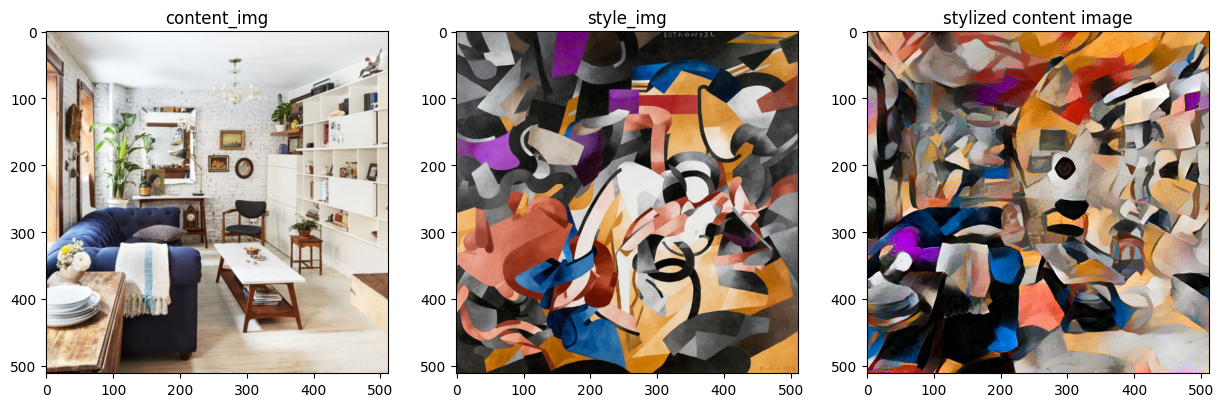

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")
display_image(output, axes[2], "stylized content image")

> ***NOTE1:*** Here we initialized the generated image using content img. According to the paper you can generate stylized image from style img, content img or even white noise. But the final generated img would be biased towards the image you initialized with. But from what I experimented with generating a good stylized image when initialized with random noise is very hard as it requires more training steps and hyperparameter tuning

> ***NOTE2:*** The most important parameters are content_weight and loss weight. In the paper the content_weight/loss_weight was never fixed but they are depended on weights, img size, learning rate and many other things. So you need to tune the parameters for different images for good visually stunning result

# Rational Behind the layers chosen for training

You must have wondered why did we used only one layer output(relu4_2) for content loss but used 5 layers feature maps for style loss. In this section we will try to figure that out

In the next three experiments we set the style weight to zero and generate image from content image feature maps only by setting the style loss to zero 

In [12]:
# using feature map of relu2_2 to generate the image
content_layers_name = ['relu2_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0  # se3tting style loss to zero
content_weight = 1  
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 0.240920 | Total Loss: 0.240920

run [100]:
Style Loss : 0.000000 | Content Loss: 0.028597 | Total Loss: 0.028597

run [150]:
Style Loss : 0.000000 | Content Loss: 0.003038 | Total Loss: 0.003038

run [200]:
Style Loss : 0.000000 | Content Loss: 0.000968 | Total Loss: 0.000968

run [250]:
Style Loss : 0.000000 | Content Loss: 0.000534 | Total Loss: 0.000534

run [300]:
Style Loss : 0.000000 | Content Loss: 0.000346 | Total Loss: 0.000346



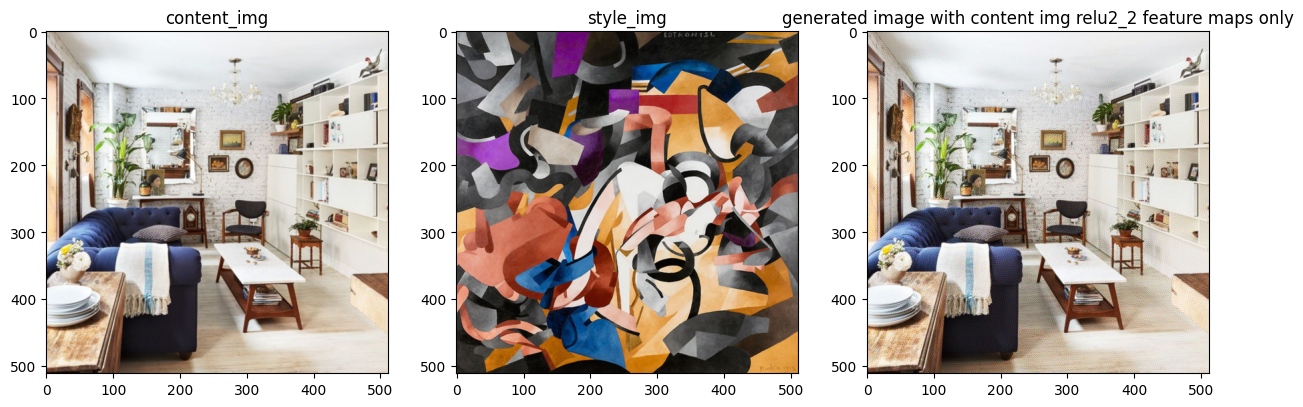

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")
display_image(output, axes[2], "generated image with content img relu2_2 feature maps only")

In [14]:
# using feature map of relu3_3 to generate the image
content_layers_name = ['relu3_3'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0 # setting style loss to zero
content_weight = 1   
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 0.124793 | Total Loss: 0.124793

run [100]:
Style Loss : 0.000000 | Content Loss: 0.065452 | Total Loss: 0.065452

run [150]:
Style Loss : 0.000000 | Content Loss: 0.042966 | Total Loss: 0.042966

run [200]:
Style Loss : 0.000000 | Content Loss: 0.030875 | Total Loss: 0.030875

run [250]:
Style Loss : 0.000000 | Content Loss: 0.023728 | Total Loss: 0.023728

run [300]:
Style Loss : 0.000000 | Content Loss: 0.018709 | Total Loss: 0.018709



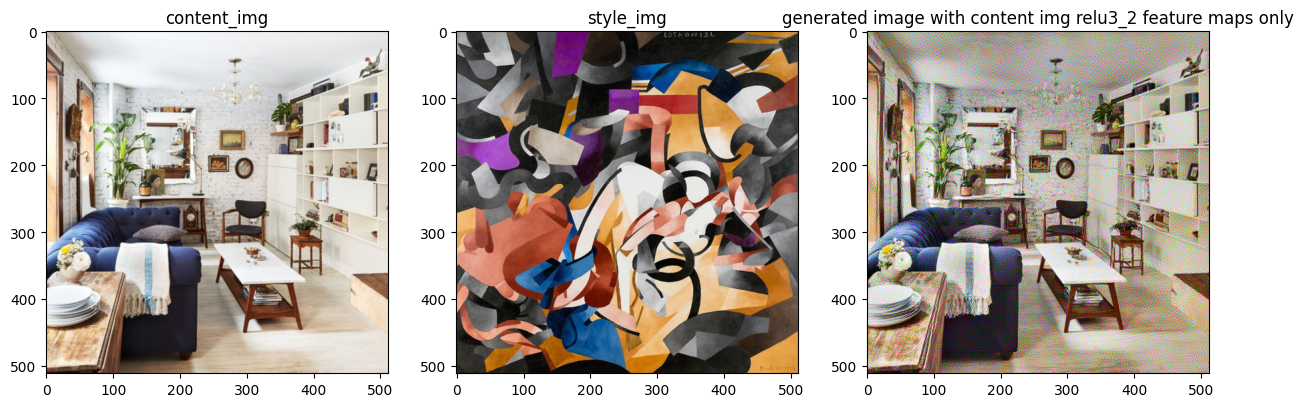

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")
display_image(output, axes[2], "generated image with content img relu3_2 feature maps only")

In [16]:
# using feature map of relu4_2 to generate the image
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 0
content_weight = 1  
style_layer_weights = [0.2] * len(style_layers_name)
content_layer_weights = [1.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 0.000000 | Content Loss: 1.004149 | Total Loss: 1.004149

run [100]:
Style Loss : 0.000000 | Content Loss: 0.578452 | Total Loss: 0.578452

run [150]:
Style Loss : 0.000000 | Content Loss: 0.416923 | Total Loss: 0.416923

run [200]:
Style Loss : 0.000000 | Content Loss: 0.331471 | Total Loss: 0.331471

run [250]:
Style Loss : 0.000000 | Content Loss: 0.276626 | Total Loss: 0.276626

run [300]:
Style Loss : 0.000000 | Content Loss: 0.235652 | Total Loss: 0.235652



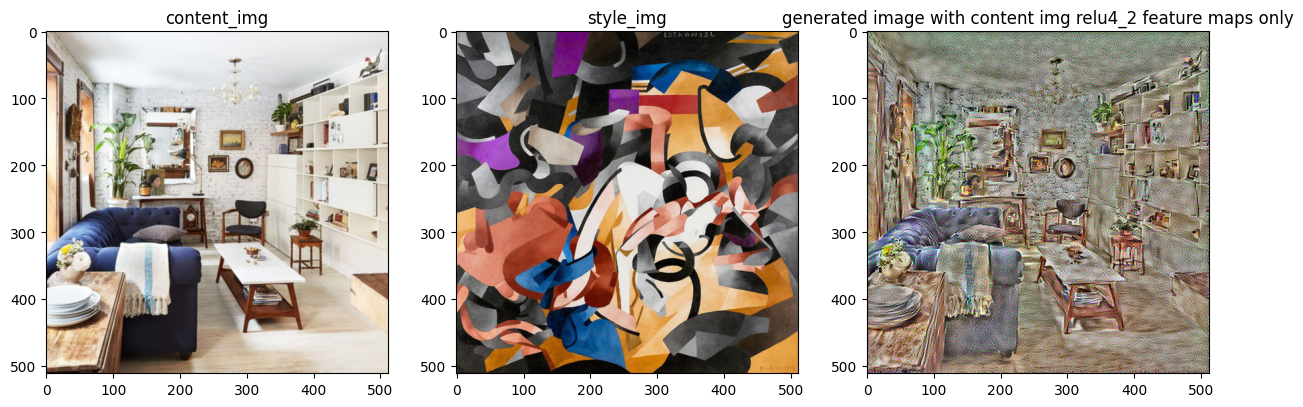

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

display_image(content_img, axes[0], "content_img")
display_image(style_img, axes[1], "style_img")
display_image(output, axes[2], "generated image with content img relu4_2 feature maps only")

We can see that as we use feature maps of deeper layers the model finds it hard to generate the image. But regardless of how deep feature maps use the content image structure are mostly preserved. But as we go deeper into the network we loss the pixel values. For style transfer we only want to preserve the content image's structures it does not matter if they loss colors or pixel values as they would be filled by style image. If we use shallow layeres feature maps the pixel values would be preserved and it would not be possible to generate a visually good sytlized image. So we used a relatively deeper layer output such as relu4_2 which captures content structure more but not the actual pixel values. You can find more about it in the paper

In the next three experiments we set the content weight to zero and increasingly used feature maps of deeper layers. We used relu1_1 and relu1_1, relu2_1, and relu1_1, relu2_1, relu3_1, relu4_1 layers feature maps

In [18]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 0.0, 0.0, 0.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=200, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 70.350449 | Content Loss: 0.000000 | Total Loss: 70.350449

run [100]:
Style Loss : 2.885045 | Content Loss: 0.000000 | Total Loss: 2.885045

run [150]:
Style Loss : 0.410672 | Content Loss: 0.000000 | Total Loss: 0.410672

run [200]:
Style Loss : 0.158672 | Content Loss: 0.000000 | Total Loss: 0.158672



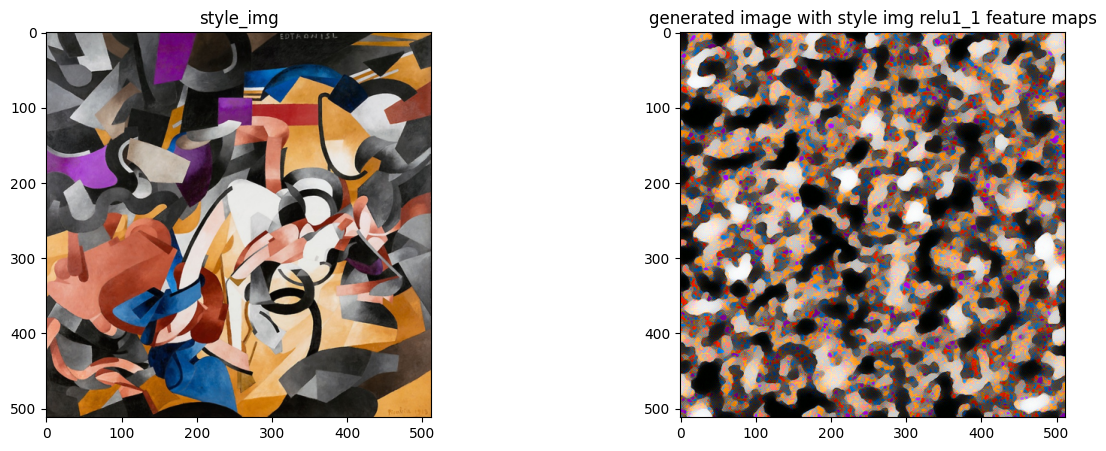

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated image with style img relu1_1 feature maps")

In [20]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 1.0, 0.0, 0.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=250, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 114.508102 | Content Loss: 0.000000 | Total Loss: 114.508102

run [100]:
Style Loss : 7.340270 | Content Loss: 0.000000 | Total Loss: 7.340270

run [150]:
Style Loss : 0.747804 | Content Loss: 0.000000 | Total Loss: 0.747804

run [200]:
Style Loss : 0.401033 | Content Loss: 0.000000 | Total Loss: 0.401033

run [250]:
Style Loss : 0.118138 | Content Loss: 0.000000 | Total Loss: 0.118138



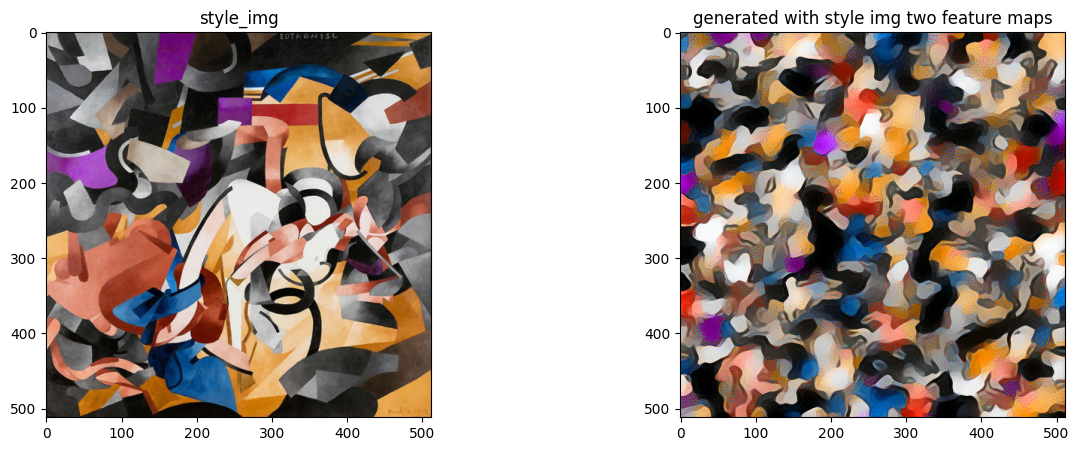

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated with style img two feature maps")

In [22]:
content_layers_name = ['relu4_2'] 
style_layers_name = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_weight = 1e7
content_weight = 0  
style_layer_weights = [1.0, 1.0, 1.0, 1.0, 0.0]
content_layer_weights = [0.0] 

assert len(content_layers_name) == len(content_layer_weights)
assert len(style_layers_name) == len(style_layer_weights)

seed_everything(CFG.seed)
generated_img = torch.rand(content_img.size()) 
output = run_style_transfer(feature_extractor, style_img, content_img, generated_img, content_layers_name, style_layers_name,
                           content_layer_weights, style_layer_weights, style_weight=style_weight, content_weight=content_weight,
                           num_steps=300, learning_rate=1)

Optimizing..
run [50]:
Style Loss : 150.408157 | Content Loss: 0.000000 | Total Loss: 150.408157

run [100]:
Style Loss : 16.556633 | Content Loss: 0.000000 | Total Loss: 16.556633

run [150]:
Style Loss : 3.302758 | Content Loss: 0.000000 | Total Loss: 3.302758

run [200]:
Style Loss : 1.415608 | Content Loss: 0.000000 | Total Loss: 1.415608

run [250]:
Style Loss : 0.808345 | Content Loss: 0.000000 | Total Loss: 0.808345

run [300]:
Style Loss : 0.537576 | Content Loss: 0.000000 | Total Loss: 0.537576



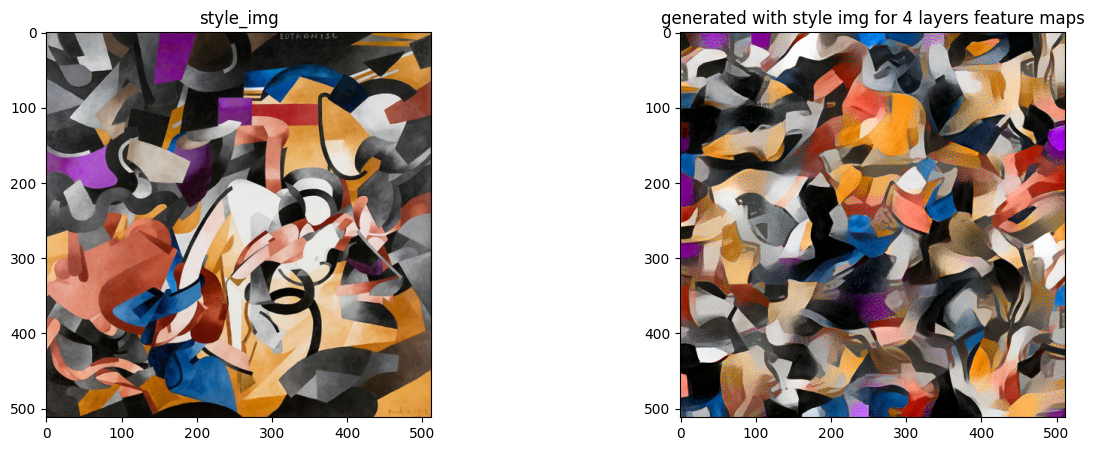

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

display_image(style_img, axes[0], "style_img")
display_image(output, axes[1], "generated with style img for 4 layers feature maps")

We can see that as we use deeper layers feature maps the more patterns of the original style image can be recovered and the size of the pattern also increase. It is because as you new the shallow layers capture simple lines, colors and textures while as we go deeper it caputes more comlex patterns and structures. It is because as we go deeper into the layers the receptive field of the pixel increases and we see more of the style image. In style transfer we use 5 layers because we want to capture colors, lines from lower levels and also more structures and patterns from deeper layers feature maps

# CONCLUSION

A Neural Algorithm of Artistic Style by Leon A. Gatys had an huge impact on style transfer methods. It can generate stylized image for any style and img size. The results are great too. But it has several problems

1. As image size increases it takes longer and longer to train as it is image optimization problem
2. Training hyper parameters are unstable and we have to tune them for different content image and style image pair


In the next notebook we will implement faster neural style which generate a stylized image in a simple forward pass though limited to only one style.